<a href="https://colab.research.google.com/github/kamnsv/deep-learning-course-practice-2025/blob/%D0%9B%D0%B0%D0%B1%D0%BE%D1%80%D0%B0%D1%82%D0%BE%D1%80%D0%BD%D0%B0%D1%8F_%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%B0_%E2%84%962_%D0%9A%D0%B0%D0%BC%D0%BD%D0%B5%D0%B2_%D0%A1.%D0%92._3824%D0%9C1%D1%81%D0%A4%D0%981/laboratory_work_1/KamnevSV/02_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лабораторная работа №2

## Окружение

In [1]:
#@title Подключение библиотек
import os
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import classification_report

In [2]:
#@title Параметры

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
g = torch.Generator()
g.manual_seed(seed)

learning_rate = 0.001
batch_size = 32
epochs = 256
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_workers = os.cpu_count()
device, num_workers

(device(type='cuda'), 12)

## Датасет

In [3]:
#@title Загрузка датасета CIFAR10
trainset = datasets.CIFAR10(root='./data', train=True, download=True,
                                        transform=transforms.ToTensor())
loader = torch.utils.data.DataLoader(trainset, batch_size=len(trainset), shuffle=False)

tensors, labels = next(iter(loader))  # batch всех изображений, размер (B, C, H, W)
mean = tensors.mean(dim=[0,2,3]) # усреднение по батчу и по пространственным осям (H, W)
std = tensors.std(dim=[0,2,3])   # std по тем же осям

print('Labels:', trainset.classes)
print('Mean:', mean)
print('Std:', std)

Labels: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Mean: tensor([0.4914, 0.4822, 0.4465])
Std: tensor([0.2470, 0.2435, 0.2616])


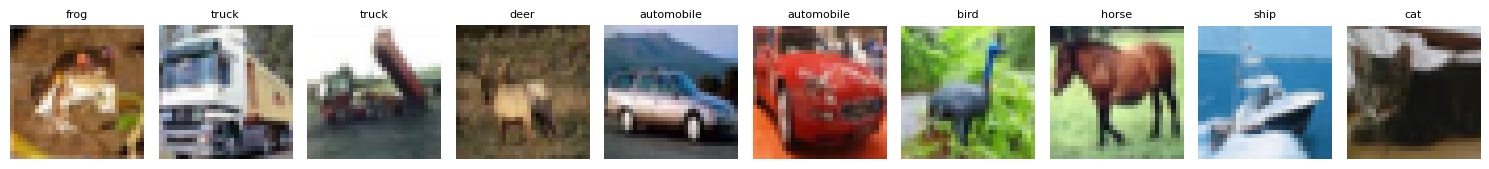

(32, 32, 3)

In [4]:
#@title Обзор
plt.figure(figsize=(15, 2))  # задаёт размер всей фигуры (широкая лента)
for i in range(10):
    image_np = tensors[i].permute(1, 2, 0).numpy()
    plt.subplot(1, 10, i + 1)  # 1 строка, 10 колонок
    plt.imshow(image_np)
    plt.title(trainset.classes[labels[i]], fontsize=8)
    plt.axis('off')
plt.tight_layout()
plt.show()
image_np.shape

In [5]:
#@title Препроцессор с аугментацией
transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2,
                           contrast=0.2,
                           saturation=0.2,
                           hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])


In [6]:
#@title Генератор батчей
train_dataset = datasets.CIFAR10(root='./data', train=True,
                                 download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True,
                                transform=transform)
def worker_init_fn(worker_id):
    worker_seed = seed + worker_id
    np.random.seed(worker_seed)
    random.seed(worker_seed)

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    generator=g,
    num_workers=num_workers
)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

len(train_dataset), len(test_dataset)

(50000, 10000)

## Обучение нейросети Pytorch

In [17]:
#@title Колбеки
# Коллбэк ReduceLROnPlateau (адаптивное изменение learning rate)
def reduce_lr_on_plateau(optimizer, val_loss, patience, factor, min_lr, best_loss, counter):
    if val_loss > best_loss:
        counter += 1
        if counter >= patience:
            for param_group in optimizer.param_groups:
                old_lr = float(param_group['lr'])
                new_lr = old_lr * factor
                if new_lr < min_lr:
                    new_lr = min_lr
                else:
                    param_group['lr'] = new_lr
                    print(f'Уменьшение learning rate с {old_lr:.8f} до {new_lr:.8f}')
            counter = 0
    else:
        counter = 0
    return counter

# Коллбэк EarlyStopping (ранняя остановка обучения)
def early_stopping(val_loss, patience, best_loss, counter):
    if val_loss > best_loss:
        counter += 1
        if counter >= patience:
            return True, counter
    else:
        counter = 0
    return False, counter

# Каждый раз сохраняет модель с минимальной ошибкой
def save_checkpoint(model, val_loss, best_loss, path_model):
  if val_loss < best_loss:
    print(f'Сохранение лучшей модели: ({best_loss:.8f} --> {val_loss:.8f})...')
    torch.save(model.state_dict(), path_model)

In [18]:
#@title Одна эпоха
def step(model, optimizer, criterion) -> tuple:
    model.train()
    train_loss = 0.0
    for x_batch, y_batch in tqdm(train_loader, desc="Train"):
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x_batch, y_batch in tqdm(test_loader, desc="Validation"):
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()

    return train_loss / len(train_loader), val_loss / len(test_loader)



In [19]:
#@title Обучение
def train(model, name, train_loader, test_loader):
  optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
  criterion = torch.nn.CrossEntropyLoss()
  print(f"Копирование модели на устройство {device}")
  model = model.to(device)
  best_loss = float('inf')
  rlr_counter = 0
  es_counter = 0
  patience_rlr = 4
  patience_es = 12
  history = []
  for epoch in range(epochs):
    train_loss, val_loss = step(model, optimizer, criterion)
    history.append({
        'loss': train_loss,
        'val_loss': val_loss,
        'lr': optimizer.param_groups[0]["lr"]
    })
    print(f'Эпоха [{epoch+1}/{epochs}], Train Loss: %(loss).8f, Val Loss: %(val_loss).8f, LR: %(lr).8f\n' % history[-1])
    rlr_counter = reduce_lr_on_plateau(optimizer, val_loss, patience_rlr, 0.1, 1e-7, best_loss, rlr_counter)
    es_stop, es_counter = early_stopping(val_loss, patience_es, best_loss, es_counter)
    save_checkpoint(model, val_loss, best_loss, f"{name}.pth")
    if val_loss < best_loss:
      best_loss = val_loss
    if es_stop:
      print(f'\nРанняя остановка обучения на эпохе №{epoch + 1}!')
      break
  return history

In [20]:
#@title График ошибки
def plot_history(history):
  plt.figure(figsize=(9, 6))
  plt.plot([i['loss'] for i in history], label='Ошибка на обучающей выборке')
  plt.plot([i['val_loss'] for i in history], label='Ошибка на тесте')
  plt.title('График уменьшения функции потерь при обучении')
  plt.xlabel('Номер эпохи')
  plt.ylabel('Loss (функция потерь)')
  plt.grid(True, linestyle='--', alpha=0.5)
  plt.legend()
  plt.tight_layout()
  plt.show()

In [22]:
#@title Проверка точности на тесте
def print_report(model):
  model.eval()
  y_pred = []
  y_test = []
  with torch.no_grad():
      for x_batch, y_batch in tqdm(test_loader, desc="Testing"):
          x_batch = x_batch.to(device)
          y_batch = y_batch.to(device)
          outputs = model(x_batch)
          preds = outputs.argmax(dim=1).cpu().numpy()
          targets = y_batch.cpu().numpy()
          y_pred.extend(preds)
          y_test.extend(targets)
  print()
  print(classification_report(y_test, y_pred, target_names=test_dataset.classes))


## Сверточная сеть

In [23]:
class ConvBlock(nn.Module):
    def __init__(self, out_channels):
        super().__init__()
        self.conv1 = nn.LazyConv2d(out_channels, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels, affine=False)
        self.gelu1 = nn.GELU()
        self.conv2 = nn.LazyConv2d(out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels, affine=False)
        self.gelu2 = nn.GELU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.gelu1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.gelu2(x)
        x = self.pool(x)
        return x

class CIFAR10(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.block1 = ConvBlock(64)
        self.block2 = ConvBlock(128)
        self.block3 = ConvBlock(256)
        self.flatten = nn.Flatten()
        self.fc = nn.LazyLinear(num_classes)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

In [24]:
#@title Инициализация весов
def lazy_weight_init(m):
  if isinstance(m, (nn.LazyLinear, nn.LazyConv2d)):
    torch.manual_seed(seed)
    nn.init.xavier_uniform_(m.weight)
    if m.bias is not None:
      nn.init.zeros_(m.bias)

In [25]:
#@title Создание и инициализация весов
model = CIFAR10()
# Прогон батча через модель для инициализации Lazy слоев
dummy_input = torch.randn(1, 3, 32, 32)
output = model(dummy_input)
model.apply(lazy_weight_init)

CIFAR10(
  (block1): ConvBlock(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (gelu1): GELU(approximate='none')
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (gelu2): GELU(approximate='none')
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): ConvBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (gelu1): GELU(approximate='none')
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    

In [26]:
 #@title Обучение модели
 h = train(model, "CIFAR10_32", train_loader, test_loader)

Копирование модели на устройство cuda


Validation: 100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:34<00:00,  9.11it/s]


Эпоха [1/256], Train Loss: 1.63015425, Val Loss: 1.37076210, LR: 0.00100000

Сохранение лучшей модели: (inf --> 1.37076210)...


Validation: 100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:23<00:00, 13.05it/s]


Эпоха [2/256], Train Loss: 1.21571032, Val Loss: 1.10369438, LR: 0.00100000

Сохранение лучшей модели: (1.37076210 --> 1.10369438)...


Validation: 100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:29<00:00, 10.49it/s]


Эпоха [3/256], Train Loss: 1.03810842, Val Loss: 0.98012070, LR: 0.00100000

Сохранение лучшей модели: (1.10369438 --> 0.98012070)...


Validation: 100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:29<00:00, 10.55it/s]


Эпоха [4/256], Train Loss: 0.93360538, Val Loss: 0.96919635, LR: 0.00100000

Сохранение лучшей модели: (0.98012070 --> 0.96919635)...


Validation: 100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:31<00:00, 10.03it/s]


Эпоха [5/256], Train Loss: 0.85985331, Val Loss: 0.80554441, LR: 0.00100000

Сохранение лучшей модели: (0.96919635 --> 0.80554441)...


Validation: 100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:24<00:00, 12.84it/s]


Эпоха [6/256], Train Loss: 0.79795474, Val Loss: 0.81029542, LR: 0.00100000



Validation: 100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:35<00:00,  8.74it/s]


Эпоха [7/256], Train Loss: 0.75479558, Val Loss: 0.70314527, LR: 0.00100000

Сохранение лучшей модели: (0.80554441 --> 0.70314527)...


Validation: 100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:31<00:00,  9.86it/s]


Эпоха [8/256], Train Loss: 0.71842545, Val Loss: 0.71826758, LR: 0.00100000



Validation: 100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:32<00:00,  9.55it/s]


Эпоха [9/256], Train Loss: 0.68991846, Val Loss: 0.69943241, LR: 0.00100000

Сохранение лучшей модели: (0.70314527 --> 0.69943241)...


Validation: 100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:32<00:00,  9.59it/s]


Эпоха [10/256], Train Loss: 0.66448450, Val Loss: 0.68159189, LR: 0.00100000

Сохранение лучшей модели: (0.69943241 --> 0.68159189)...


Validation: 100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:28<00:00, 10.90it/s]


Эпоха [11/256], Train Loss: 0.64313467, Val Loss: 0.80298291, LR: 0.00100000



Validation: 100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:59<00:00,  5.26it/s]


Эпоха [12/256], Train Loss: 0.61826557, Val Loss: 0.70716688, LR: 0.00100000



Validation: 100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:11<00:00, 27.59it/s]


Эпоха [13/256], Train Loss: 0.60723300, Val Loss: 0.64518164, LR: 0.00100000

Сохранение лучшей модели: (0.68159189 --> 0.64518164)...


Validation: 100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:12<00:00, 25.73it/s]


Эпоха [14/256], Train Loss: 0.58803251, Val Loss: 0.62735279, LR: 0.00100000

Сохранение лучшей модели: (0.64518164 --> 0.62735279)...


Validation: 100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:12<00:00, 24.88it/s]


Эпоха [15/256], Train Loss: 0.57108046, Val Loss: 0.61746741, LR: 0.00100000

Сохранение лучшей модели: (0.62735279 --> 0.61746741)...


Validation: 100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:34<00:00,  9.06it/s]


Эпоха [16/256], Train Loss: 0.55373180, Val Loss: 0.66900938, LR: 0.00100000



Validation: 100%|█████████████████████████████████████████████████████████████████████| 313/313 [01:28<00:00,  3.55it/s]


Эпоха [17/256], Train Loss: 0.53773412, Val Loss: 0.61251066, LR: 0.00100000

Сохранение лучшей модели: (0.61746741 --> 0.61251066)...


Validation: 100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:46<00:00,  6.76it/s]


Эпоха [18/256], Train Loss: 0.54001565, Val Loss: 0.61019459, LR: 0.00100000

Сохранение лучшей модели: (0.61251066 --> 0.61019459)...


Validation: 100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:52<00:00,  5.96it/s]


Эпоха [19/256], Train Loss: 0.52751362, Val Loss: 0.57935527, LR: 0.00100000

Сохранение лучшей модели: (0.61019459 --> 0.57935527)...


Validation: 100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:19<00:00, 15.99it/s]


Эпоха [20/256], Train Loss: 0.51110301, Val Loss: 0.57787273, LR: 0.00100000

Сохранение лучшей модели: (0.57935527 --> 0.57787273)...


Validation: 100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:15<00:00, 20.23it/s]


Эпоха [21/256], Train Loss: 0.49988023, Val Loss: 0.55755777, LR: 0.00100000

Сохранение лучшей модели: (0.57787273 --> 0.55755777)...


Validation: 100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:19<00:00, 16.07it/s]


Эпоха [22/256], Train Loss: 0.49804707, Val Loss: 0.56978626, LR: 0.00100000



Validation: 100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:13<00:00, 23.98it/s]


Эпоха [23/256], Train Loss: 0.48406611, Val Loss: 0.55818788, LR: 0.00100000



Validation: 100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:17<00:00, 17.67it/s]


Эпоха [24/256], Train Loss: 0.47954020, Val Loss: 0.55115297, LR: 0.00100000

Сохранение лучшей модели: (0.55755777 --> 0.55115297)...


Validation: 100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:14<00:00, 21.21it/s]


Эпоха [25/256], Train Loss: 0.47289668, Val Loss: 0.59244903, LR: 0.00100000



Validation: 100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:18<00:00, 17.25it/s]


Эпоха [26/256], Train Loss: 0.45785533, Val Loss: 0.53257916, LR: 0.00100000

Сохранение лучшей модели: (0.55115297 --> 0.53257916)...


Validation: 100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:21<00:00, 14.67it/s]


Эпоха [27/256], Train Loss: 0.45631832, Val Loss: 0.52987171, LR: 0.00100000

Сохранение лучшей модели: (0.53257916 --> 0.52987171)...


Validation: 100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:41<00:00,  7.63it/s]


Эпоха [28/256], Train Loss: 0.45314214, Val Loss: 0.53651120, LR: 0.00100000



Validation: 100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:32<00:00,  9.56it/s]


Эпоха [29/256], Train Loss: 0.44525905, Val Loss: 0.56022669, LR: 0.00100000



Validation: 100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:30<00:00, 10.34it/s]


Эпоха [30/256], Train Loss: 0.43797183, Val Loss: 0.49938062, LR: 0.00100000

Сохранение лучшей модели: (0.52987171 --> 0.49938062)...


Validation: 100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:19<00:00, 15.95it/s]


Эпоха [31/256], Train Loss: 0.42972276, Val Loss: 0.61591984, LR: 0.00100000



Validation: 100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:21<00:00, 14.51it/s]


Эпоха [32/256], Train Loss: 0.42701298, Val Loss: 0.50099451, LR: 0.00100000



Validation: 100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:19<00:00, 16.06it/s]


Эпоха [33/256], Train Loss: 0.42247767, Val Loss: 0.51035000, LR: 0.00100000



Validation: 100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:22<00:00, 13.76it/s]


Эпоха [34/256], Train Loss: 0.41736144, Val Loss: 0.49247475, LR: 0.00100000

Сохранение лучшей модели: (0.49938062 --> 0.49247475)...


Validation: 100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:23<00:00, 13.04it/s]


Эпоха [35/256], Train Loss: 0.41041934, Val Loss: 0.49187529, LR: 0.00100000

Сохранение лучшей модели: (0.49247475 --> 0.49187529)...


Validation: 100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:30<00:00, 10.14it/s]


Эпоха [36/256], Train Loss: 0.40624964, Val Loss: 0.50446602, LR: 0.00100000



Validation: 100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:35<00:00,  8.94it/s]


Эпоха [37/256], Train Loss: 0.40443468, Val Loss: 0.49155687, LR: 0.00100000

Сохранение лучшей модели: (0.49187529 --> 0.49155687)...


Validation: 100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:33<00:00,  9.48it/s]


Эпоха [38/256], Train Loss: 0.39568313, Val Loss: 0.51438017, LR: 0.00100000



Validation: 100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:20<00:00, 15.63it/s]


Эпоха [39/256], Train Loss: 0.39236652, Val Loss: 0.47661283, LR: 0.00100000

Сохранение лучшей модели: (0.49155687 --> 0.47661283)...


Validation: 100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:22<00:00, 14.14it/s]


Эпоха [40/256], Train Loss: 0.39261332, Val Loss: 0.55174992, LR: 0.00100000



Validation: 100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:30<00:00, 10.13it/s]


Эпоха [41/256], Train Loss: 0.38946470, Val Loss: 0.51185471, LR: 0.00100000



Validation: 100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:24<00:00, 12.81it/s]


Эпоха [42/256], Train Loss: 0.38141372, Val Loss: 0.45421375, LR: 0.00100000

Сохранение лучшей модели: (0.47661283 --> 0.45421375)...


Validation: 100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:20<00:00, 15.13it/s]


Эпоха [43/256], Train Loss: 0.37761533, Val Loss: 0.50619687, LR: 0.00100000



Validation: 100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:22<00:00, 13.70it/s]


Эпоха [44/256], Train Loss: 0.38138738, Val Loss: 0.50378195, LR: 0.00100000



Validation: 100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:26<00:00, 11.61it/s]


Эпоха [45/256], Train Loss: 0.37522573, Val Loss: 0.49706402, LR: 0.00100000



Validation: 100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:23<00:00, 13.41it/s]


Эпоха [46/256], Train Loss: 0.37272304, Val Loss: 0.49462157, LR: 0.00100000

Уменьшение learning rate с 0.00100000 до 0.00010000


Validation: 100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:24<00:00, 12.72it/s]


Эпоха [47/256], Train Loss: 0.27284100, Val Loss: 0.39581297, LR: 0.00010000

Сохранение лучшей модели: (0.45421375 --> 0.39581297)...


Validation: 100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:24<00:00, 12.67it/s]


Эпоха [48/256], Train Loss: 0.25166490, Val Loss: 0.39387719, LR: 0.00010000

Сохранение лучшей модели: (0.39581297 --> 0.39387719)...


Validation: 100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:21<00:00, 14.85it/s]


Эпоха [49/256], Train Loss: 0.24045403, Val Loss: 0.39111737, LR: 0.00010000

Сохранение лучшей модели: (0.39387719 --> 0.39111737)...


Validation: 100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:19<00:00, 15.70it/s]


Эпоха [50/256], Train Loss: 0.23678241, Val Loss: 0.38157352, LR: 0.00010000

Сохранение лучшей модели: (0.39111737 --> 0.38157352)...


Validation: 100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:19<00:00, 15.80it/s]


Эпоха [51/256], Train Loss: 0.23049006, Val Loss: 0.39174033, LR: 0.00010000



Validation: 100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:18<00:00, 16.77it/s]


Эпоха [52/256], Train Loss: 0.23015374, Val Loss: 0.38818353, LR: 0.00010000



Validation: 100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:20<00:00, 15.07it/s]


Эпоха [53/256], Train Loss: 0.22175591, Val Loss: 0.39254570, LR: 0.00010000



Validation: 100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:26<00:00, 12.00it/s]


Эпоха [54/256], Train Loss: 0.22093101, Val Loss: 0.38779643, LR: 0.00010000

Уменьшение learning rate с 0.00010000 до 0.00001000


Validation: 100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:31<00:00,  9.97it/s]


Эпоха [55/256], Train Loss: 0.20817649, Val Loss: 0.37068305, LR: 0.00001000

Сохранение лучшей модели: (0.38157352 --> 0.37068305)...


Validation: 100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:19<00:00, 15.86it/s]


Эпоха [56/256], Train Loss: 0.21135732, Val Loss: 0.38598419, LR: 0.00001000



Validation: 100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:23<00:00, 13.54it/s]


Эпоха [57/256], Train Loss: 0.21045009, Val Loss: 0.37961217, LR: 0.00001000



Validation: 100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:22<00:00, 14.22it/s]


Эпоха [58/256], Train Loss: 0.20618569, Val Loss: 0.38199614, LR: 0.00001000



Validation: 100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:27<00:00, 11.40it/s]


Эпоха [59/256], Train Loss: 0.20657563, Val Loss: 0.37936052, LR: 0.00001000

Уменьшение learning rate с 0.00001000 до 0.00000100


Validation: 100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:20<00:00, 14.91it/s]


Эпоха [60/256], Train Loss: 0.20614394, Val Loss: 0.37818039, LR: 0.00000100



Validation: 100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:20<00:00, 14.93it/s]


Эпоха [61/256], Train Loss: 0.20535011, Val Loss: 0.36912371, LR: 0.00000100

Сохранение лучшей модели: (0.37068305 --> 0.36912371)...


Validation: 100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:22<00:00, 13.88it/s]


Эпоха [62/256], Train Loss: 0.20404245, Val Loss: 0.38315975, LR: 0.00000100



Validation: 100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:13<00:00, 22.83it/s]


Эпоха [63/256], Train Loss: 0.20574453, Val Loss: 0.37601923, LR: 0.00000100



Validation: 100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:15<00:00, 19.79it/s]


Эпоха [64/256], Train Loss: 0.20492940, Val Loss: 0.38292334, LR: 0.00000100



Validation: 100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:17<00:00, 17.93it/s]


Эпоха [65/256], Train Loss: 0.20457329, Val Loss: 0.38123247, LR: 0.00000100

Уменьшение learning rate с 0.00000100 до 0.00000010


Validation: 100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:12<00:00, 24.50it/s]


Эпоха [66/256], Train Loss: 0.20659757, Val Loss: 0.37621391, LR: 0.00000010



Validation: 100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:13<00:00, 23.90it/s]


Эпоха [67/256], Train Loss: 0.20580330, Val Loss: 0.37149532, LR: 0.00000010



Validation: 100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:13<00:00, 23.85it/s]


Эпоха [68/256], Train Loss: 0.20403773, Val Loss: 0.37409006, LR: 0.00000010



Validation: 100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:14<00:00, 22.26it/s]


Эпоха [69/256], Train Loss: 0.20401010, Val Loss: 0.36562794, LR: 0.00000010

Сохранение лучшей модели: (0.36912371 --> 0.36562794)...


Validation: 100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:14<00:00, 21.99it/s]


Эпоха [70/256], Train Loss: 0.20448748, Val Loss: 0.37595162, LR: 0.00000010



Validation: 100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:10<00:00, 28.82it/s]


Эпоха [71/256], Train Loss: 0.20403371, Val Loss: 0.37556653, LR: 0.00000010



Validation: 100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:09<00:00, 32.26it/s]


Эпоха [72/256], Train Loss: 0.20725717, Val Loss: 0.38614761, LR: 0.00000010



Validation: 100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:13<00:00, 23.61it/s]


Эпоха [73/256], Train Loss: 0.20538223, Val Loss: 0.37224582, LR: 0.00000010



Validation: 100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:11<00:00, 27.32it/s]


Эпоха [74/256], Train Loss: 0.20528500, Val Loss: 0.37894787, LR: 0.00000010



Validation: 100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:15<00:00, 20.52it/s]


Эпоха [75/256], Train Loss: 0.20440567, Val Loss: 0.38573995, LR: 0.00000010



Validation: 100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:21<00:00, 14.46it/s]


Эпоха [76/256], Train Loss: 0.20199809, Val Loss: 0.36212891, LR: 0.00000010

Сохранение лучшей модели: (0.36562794 --> 0.36212891)...


Validation: 100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:14<00:00, 20.97it/s]


Эпоха [77/256], Train Loss: 0.20300102, Val Loss: 0.38118037, LR: 0.00000010



Validation: 100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:13<00:00, 24.05it/s]


Эпоха [78/256], Train Loss: 0.20327492, Val Loss: 0.38165943, LR: 0.00000010



Validation: 100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:11<00:00, 27.08it/s]


Эпоха [79/256], Train Loss: 0.20207958, Val Loss: 0.36966017, LR: 0.00000010



Validation: 100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:23<00:00, 13.15it/s]


Эпоха [80/256], Train Loss: 0.20316633, Val Loss: 0.36658445, LR: 0.00000010



Validation: 100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:17<00:00, 17.52it/s]


Эпоха [81/256], Train Loss: 0.20594133, Val Loss: 0.37988626, LR: 0.00000010



Validation: 100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:18<00:00, 16.74it/s]


Эпоха [82/256], Train Loss: 0.20436289, Val Loss: 0.37426768, LR: 0.00000010



Validation: 100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:24<00:00, 12.61it/s]


Эпоха [83/256], Train Loss: 0.20442555, Val Loss: 0.36840524, LR: 0.00000010



Validation: 100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:19<00:00, 15.96it/s]


Эпоха [84/256], Train Loss: 0.20520231, Val Loss: 0.36227373, LR: 0.00000010



Validation: 100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:20<00:00, 15.33it/s]


Эпоха [85/256], Train Loss: 0.20291713, Val Loss: 0.39111436, LR: 0.00000010



Validation: 100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:19<00:00, 16.12it/s]


Эпоха [86/256], Train Loss: 0.20603552, Val Loss: 0.36242739, LR: 0.00000010



Validation: 100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:23<00:00, 13.43it/s]


Эпоха [87/256], Train Loss: 0.20590999, Val Loss: 0.37540581, LR: 0.00000010



Validation: 100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:19<00:00, 16.10it/s]

Эпоха [88/256], Train Loss: 0.20536521, Val Loss: 0.38025485, LR: 0.00000010


Ранняя остановка обучения на эпохе №88!


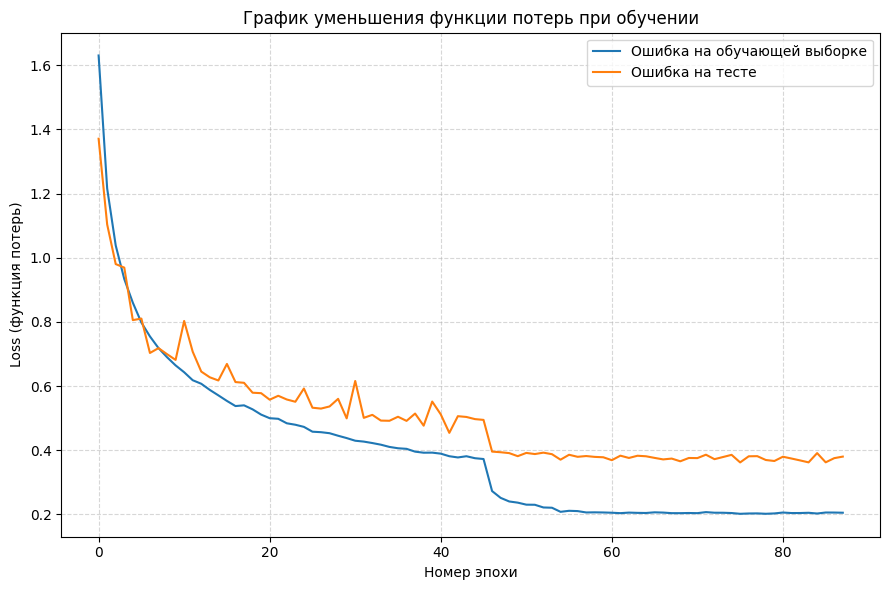

In [27]:
#@title График ошибки
plot_history(h)

In [28]:
#@title Проверка точности на тесте
model.load_state_dict(torch.load('CIFAR10_32.pth'))
print_report(model)

Testing: 100%|████████████████████████████████████████████████████████████████████████| 313/313 [00:15<00:00, 20.08it/s]


              precision    recall  f1-score   support

    airplane       0.88      0.90      0.89      1000
  automobile       0.94      0.94      0.94      1000
        bird       0.86      0.81      0.83      1000
         cat       0.74      0.78      0.76      1000
        deer       0.86      0.88      0.87      1000
         dog       0.83      0.79      0.81      1000
        frog       0.91      0.93      0.92      1000
       horse       0.92      0.89      0.91      1000
        ship       0.93      0.94      0.93      1000
       truck       0.91      0.91      0.91      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000

